<a href="https://colab.research.google.com/github/Ivan137950/Stocks/blob/main/Stocks_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, roc_auc_score

# from sklearn.preprocessing import MinMaxScaler
!pip install numba
from numba import cuda
# device = cuda.get_current_device()
# device.reset()

In [ ]:
!ls

drive  sample_data


In [ ]:
from google.colab import drive
drive.mount('Drive')

Mounted at Drive


In [ ]:
!unzip "/content/Drive/MyDrive/DATA.zip" -d "/content/Drive/MyDrive/Datasets"

Archive:  /content/Drive/MyDrive/DATA.zip
replace /content/Drive/MyDrive/Datasets/label_first_metric/MRSB_label_first_metric.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/MRSB_label_first_metric.txt  
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/YNDX_label_first_metric.txt  
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/MSNG_label_first_metric.txt  
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/LENT_label_first_metric.txt  
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/FEES_label_first_metric.txt  
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/GMKN_label_first_metric.txt  
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/MOEX_label_first_metric.txt  
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/LVHK_label_first_metric.txt  
  inflating: /content/Drive/MyDrive/Datasets/label_first_metric/AFLT_label_fir

In [ ]:
stocks = ['SBER', 'T', 'MOEX', 'YNDX', 'GMKN', 'AFLT', 'BANE',
          'MSNG', 'LENT', 'LKOH', 'LVHK', 'MRSB', 'FEES']
names_of_dirs = ['Data' ,'label_first_metric' ,'label_second_metric']
features_names = np.array([stock + "_" + names_of_dirs[0] for stock in stocks])
labels_names_1 = np.array([stock + "_" + names_of_dirs[1] for stock in stocks])
labels_names_2 = np.array([stock + "_" + names_of_dirs[2] for stock in stocks])


In [ ]:
data = {name: {} for name in names_of_dirs}
used_names = set()
root_direct = "/content/Drive/MyDrive/Datasets/"
for name in names_of_dirs:
    for stock in stocks:
      input = []
      with open(root_direct + name + "/" + stock + "_" + name + ".txt") as f:
        input = [float(string) for string in f]
      if(len(input) > 70000):      # убираем неприлично маленькие наборы данных
        data[name][stock] =np.array(input)
        used_names.add(stock)
# /content/drive/MyDrive/Datasets/Data/SBER_Data.txt

Попробуем построить нейронную сеть которая была бы способна предсказывать, что в "ближайшем будущем будет повышение цены".
Первая модель не будет *RNN* в привычном понимании. Я бы назвал её
 "*блочой RNN*"

In [ ]:
datafr_1 = {"features": {name: data['Data'][name]
                         for name in used_names},
            "labels":  data['label_first_metric']}
df = pd.DataFrame(datafr_1)
df

,features,labels
LKOH,"[5715.0, 5710.0, 5697.0, 5698.5, 5700.0, 5692....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
FEES,"[0.21694, 0.21694, 0.21684, 0.21684, 0.21682, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
AFLT,"[70.82, 70.8, 70.76, 70.76, 70.8, 70.8, 70.8, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
MOEX,"[158.2, 158.35, 158.35, 158.32, 158.23, 158.19...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
SBER,"[271.7, 271.71, 271.44, 271.5, 271.28, 271.27,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
GMKN,"[254.78, 254.46, 254.24, 254.0, 253.88, 253.92...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
T,"[3254.8, 3259.8, 3253.8, 3252.2, 3252.0, 3246....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
# for label in df['labels']:
for stock, label in zip(df.index, df['labels']):

  print(f'{sum(label) / len(label): 4e}, {stock}')

 3.449533e-01, LKOH
 4.258900e-01, FEES
 4.061856e-01, AFLT
 3.889797e-01, MOEX
 3.506696e-01, SBER
 3.604733e-01, GMKN
 5.046771e-01, T


In [ ]:
# Добавляем новый столбец, в котором будем считать количество единиц в 'labels'
dat = df
dat['count_ones'] = dat['labels'].apply(
    lambda x: sum(1 for i in x if i == 1.0) / len(x))
df_sorted = dat.sort_values(by='count_ones', ascending=False)

# Выводим отсортированный DataFrame
print(df_sorted['count_ones'])

T       0.504677
FEES    0.425890
AFLT    0.406186
MOEX    0.388980
GMKN    0.360473
SBER    0.350670
LKOH    0.344953
Name: count_ones, dtype: float64


In [ ]:
import numpy as np
import torch
import pandas as pd

class Data():
    def __init__(self, features, labels, step):
        print(type(features), type(labels))

        # Приведение данных к числовому типу, если это необходимо
        features = np.array(features, dtype=np.float32)
        labels = np.array(labels, dtype=np.float32)

        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

        training_data_len = math.ceil(len(self.features)*.6)
        self.train_features = self.features[:training_data_len]
        self.val_features  = self.features[training_data_len:]

        # Преобразование меток в torch.long
        self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
        self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)

        # Минмакс нормализация
        self.min_max_features = self.min_max_1D()
        self.min_max_train_features = self.min_max_features[:training_data_len]
        self.min_max_val_features  = self.min_max_features[training_data_len:]

        # Преобразование данных в формат для обучения
        self.x = torch.tensor(self.some_type_of_reshape(step), dtype=torch.float32)
        self.x_train = self.x[:training_data_len]
        self.x_val  = self.x[training_data_len:]

    def min_max_1D(self):
        min_arr = torch.min(self.features)
        max_arr = torch.max(self.features)
        result = (self.features - min_arr) / (max_arr - min_arr)
        return result

    def some_type_of_reshape(self, step):
        array = self.min_max_features
        if len(array) < step:
            return array
        else:
            result = np.array([array[i: i + step] for i in range(len(array) - step)])
        return result


# Пример вызова
dfr = Data(df['features']['T'], df['labels']['T'], 160)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-10-72d26b0a981b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
<ipython-input-10-72d26b0a981b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)


In [ ]:
# Define the network class
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(160, 128)
        self.bn1 = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 8)
        self.bn3 = nn.BatchNorm1d(8)

        self.fc4 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        # x = nn.functional.leaky_relu(x, negative_slope=0.01)
        x = nn.functional.relu(x)

        x = self.fc2(x)
        x = self.bn2(x)
        # x = nn.functional.leaky_relu(x, negative_slope=0.01)
        x = nn.functional.relu(x)

        x = self.fc3(x)
        x = self.bn3(x)
        # x = nn.functional.leaky_relu(x, negative_slope=0.01)
        x = nn.functional.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        # x = nn.Dropout(p=0.1)
        x = torch.sigmoid(x)
        return x

In [ ]:
def accuracy(predictions, labels):
  pr = predictions
  lab = labels
  preds = torch.round(pr)  # Преобразуем предсказания в бинарные метки (0 или 1)
  return accuracy_score(lab.detach().cpu().numpy(), preds.detach().cpu().numpy())  # .detach() отделяет от графа


def false_positive_only(predictions, labels):
  pr = predictions
  preds = torch.round(pr)  # Преобразуем предсказания в бинарные метки (0 или 1)
  fp = ((preds == 1) & (labels == 0)).sum().item()
  return fp

def build_ANN(dfr, num_epochs, bs):
    X_train = dfr.x_train
    Y_train = dfr.y_train
    X_val = dfr.x_val
    Y_val = dfr.y_val

    model = SimpleNet()

    loss_fn = nn.BCELoss()
    batch_size = bs
    train_dataset = TensorDataset(X_train, Y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(X_val, Y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    train_hist = []
    val_hist = []
    train_acc_hist = []
    val_acc_hist = []

    learning_rate = 0.00001
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    control = sum(torch.round(Y_val)) / len(torch.round(Y_val))

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0.0
        correct_preds = 0
        total_preds = 0
        total_fp = 0.0  # Для суммы процентов ложноположительных ошибок в тренировочной фазе
        total_batches = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to('cpu'), batch_y.to('cpu')

            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y.view(-1, 1))  # Приводим метки к типу float
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            acc = accuracy(predictions, batch_y)
            correct_preds += acc * len(batch_y)
            total_preds += len(batch_y)

            # Calculate false positive percentage for this batch
            fp = false_positive_only(predictions, batch_y)
            total_fp += fp
            total_batches += 1

        # Calculate average false positive percentage for the epoch
        average_fp = total_fp / (total_batches*160)

        average_loss = total_loss / len(train_loader)
        average_acc = correct_preds / total_preds

        train_hist.append(average_loss)
        train_acc_hist.append(average_acc)

        # Validation phase
        model.eval()
        with torch.no_grad():
            total_val_loss = 0.0
            val_correct_preds = 0
            val_total_preds = 0
            total_val_fp = 0.0  # Для суммы процентов ложноположительных ошибок в валидационной фазе
            val_total_batches = 0

            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.to('cpu'), batch_y_val.to('cpu')

                predictions_val = model(batch_X_val)
                val_loss = loss_fn(predictions_val, batch_y_val.view(-1, 1))

                total_val_loss += val_loss.item()

                # Calculate validation accuracy
                val_acc = accuracy(predictions_val, batch_y_val)
                val_correct_preds += val_acc * len(batch_y_val)
                val_total_preds += len(batch_y_val)

                # Calculate false positive percentage for this batch
                fp_val = false_positive_only(predictions_val, batch_y_val)
                total_val_fp += fp_val
                val_total_batches += 1

            # Calculate average false positive percentage for the epoch
            average_val_fp = total_val_fp / (val_total_batches*160)

            average_val_loss = total_val_loss / len(val_loader)
            average_val_acc = val_correct_preds / val_total_preds

            val_hist.append(average_val_loss)
            val_acc_hist.append(average_val_acc)
            cont = sum(torch.round(predictions_val)) / len(torch.round(predictions_val))
            diff = cont - control

        # Print metrics
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Val Loss: {average_val_loss:.4f}, '
              f'Training Accuracy: {average_acc:.4f}, Val Accuracy: {average_val_acc:.4f}, '
              # f'Training FP: {average_fp:.4f}, Val FP: {average_val_fp:.4f}, '
              f'Difference: ABS: {diff}, APPR: {diff / control}')
        # if -0.05 < diff < 0.01:
        #   break

    return model, train_hist, val_hist, train_acc_hist, val_acc_hist


def plot_loss(train_hist, val_hist, name, num_epochs):
  # num_epochs = 10
  x = np.linspace(1,num_epochs,num_epochs)
  plt.plot(x,train_hist,scalex=True, label="Training " + name)
  plt.plot(x, val_hist, label="Val " + name)
  plt.legend()
  plt.show()

def plot_current_loss(dictionary, names, title, num_epochs):
  # num_epochs = 10
  x = np.linspace(1,num_epochs,num_epochs)
  for name in names:
    plt.plot(x,dictionary[name], scalex=True, label=name)
  plt.legend()
  plt.title(title)
  plt.show()



In [ ]:
os.system('mkdir /content/drive/MyDrive/models')

256

In [ ]:
used_names

{'AFLT', 'FEES', 'GMKN', 'LKOH', 'MOEX', 'SBER', 'T'}

Судя по всему, дальнейшей обработке имеет смысл подвергать только LKOH и SBER

LKOH
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-10-72d26b0a981b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
<ipython-input-10-72d26b0a981b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)


Epoch [1/200] - Training Loss: 0.7475, Val Loss: 0.7155, Training Accuracy: 0.4110, Val Accuracy: 0.4188, Difference: ABS: tensor([0.5363]), APPR: tensor([1.9415])
Epoch [2/200] - Training Loss: 0.7253, Val Loss: 0.7222, Training Accuracy: 0.4311, Val Accuracy: 0.3879, Difference: ABS: tensor([0.6613]), APPR: tensor([2.3941])
Epoch [3/200] - Training Loss: 0.7161, Val Loss: 0.7065, Training Accuracy: 0.4500, Val Accuracy: 0.5016, Difference: ABS: tensor([0.5363]), APPR: tensor([1.9415])
Epoch [4/200] - Training Loss: 0.7065, Val Loss: 0.7087, Training Accuracy: 0.4755, Val Accuracy: 0.5227, Difference: ABS: tensor([0.4738]), APPR: tensor([1.7153])
Epoch [5/200] - Training Loss: 0.7011, Val Loss: 0.7061, Training Accuracy: 0.4955, Val Accuracy: 0.4948, Difference: ABS: tensor([0.4738]), APPR: tensor([1.7153])
Epoch [6/200] - Training Loss: 0.6929, Val Loss: 0.7057, Training Accuracy: 0.5133, Val Accuracy: 0.5394, Difference: ABS: tensor([0.5363]), APPR: tensor([1.9415])
Epoch [7/200] - 

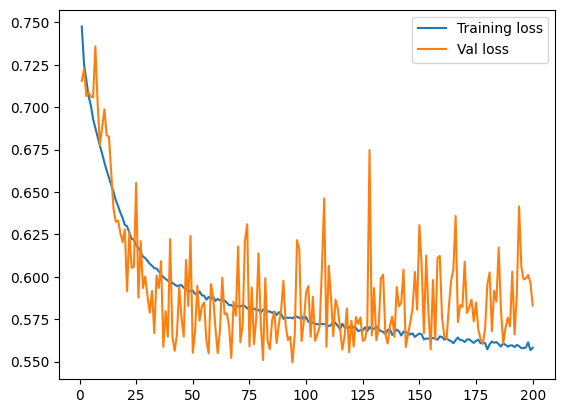

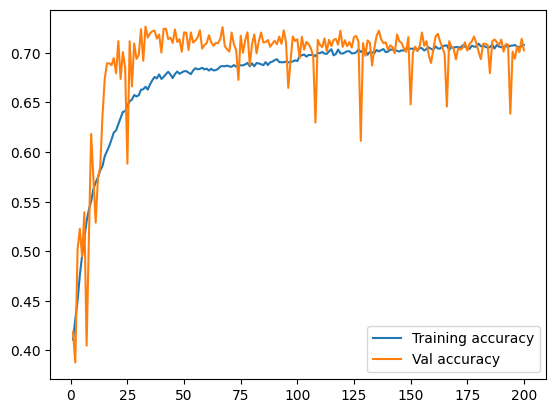

FEES
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-10-72d26b0a981b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
<ipython-input-10-72d26b0a981b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)


Epoch [1/200] - Training Loss: 0.6198, Val Loss: 0.7004, Training Accuracy: 0.6432, Val Accuracy: 0.4961, Difference: ABS: tensor([-0.2416]), APPR: tensor([-0.4739])
Epoch [2/200] - Training Loss: 0.6007, Val Loss: 0.6989, Training Accuracy: 0.6620, Val Accuracy: 0.4882, Difference: ABS: tensor([0.0267]), APPR: tensor([0.0523])
Epoch [3/200] - Training Loss: 0.5943, Val Loss: 0.6982, Training Accuracy: 0.6709, Val Accuracy: 0.4972, Difference: ABS: tensor([0.0267]), APPR: tensor([0.0523])
Epoch [4/200] - Training Loss: 0.5910, Val Loss: 0.6980, Training Accuracy: 0.6752, Val Accuracy: 0.5051, Difference: ABS: tensor([0.0998]), APPR: tensor([0.1958])
Epoch [5/200] - Training Loss: 0.5899, Val Loss: 0.6986, Training Accuracy: 0.6744, Val Accuracy: 0.4994, Difference: ABS: tensor([-0.0221]), APPR: tensor([-0.0434])
Epoch [6/200] - Training Loss: 0.5892, Val Loss: 0.6981, Training Accuracy: 0.6750, Val Accuracy: 0.5034, Difference: ABS: tensor([0.0023]), APPR: tensor([0.0045])
Epoch [7/200

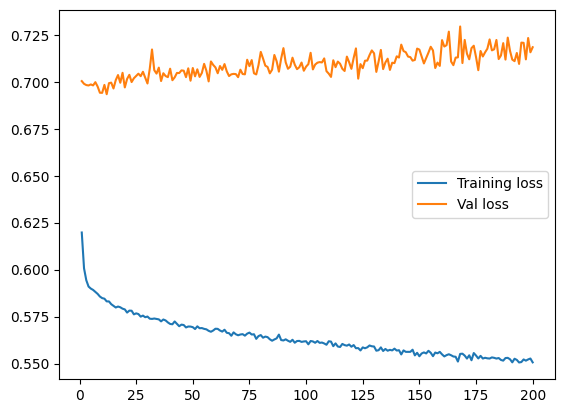

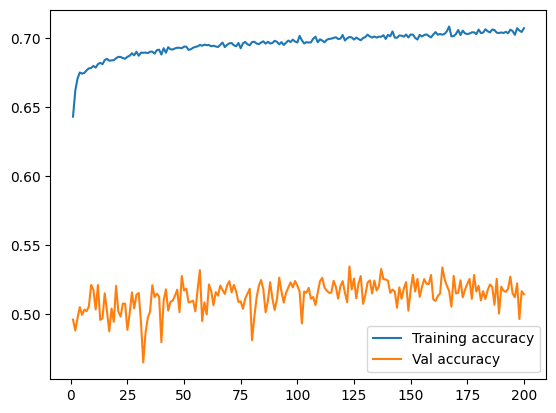

AFLT
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-10-72d26b0a981b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
<ipython-input-10-72d26b0a981b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)


Epoch [1/200] - Training Loss: 0.6987, Val Loss: 0.6907, Training Accuracy: 0.5145, Val Accuracy: 0.5184, Difference: ABS: tensor([0.4248]), APPR: tensor([0.9437])
Epoch [2/200] - Training Loss: 0.6777, Val Loss: 0.6888, Training Accuracy: 0.5594, Val Accuracy: 0.5415, Difference: ABS: tensor([0.2373]), APPR: tensor([0.5272])
Epoch [3/200] - Training Loss: 0.6719, Val Loss: 0.6896, Training Accuracy: 0.5639, Val Accuracy: 0.5641, Difference: ABS: tensor([0.0498]), APPR: tensor([0.1107])
Epoch [4/200] - Training Loss: 0.6657, Val Loss: 0.6799, Training Accuracy: 0.5727, Val Accuracy: 0.5902, Difference: ABS: tensor([0.0498]), APPR: tensor([0.1107])
Epoch [5/200] - Training Loss: 0.6644, Val Loss: 0.6843, Training Accuracy: 0.5750, Val Accuracy: 0.5779, Difference: ABS: tensor([0.2998]), APPR: tensor([0.6660])
Epoch [6/200] - Training Loss: 0.6603, Val Loss: 0.6868, Training Accuracy: 0.5854, Val Accuracy: 0.5861, Difference: ABS: tensor([-0.0752]), APPR: tensor([-0.1670])
Epoch [7/200] 

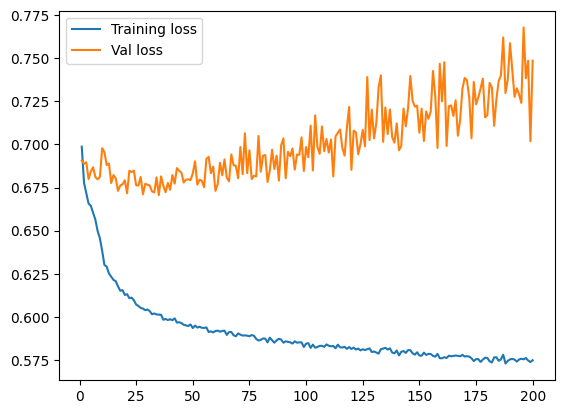

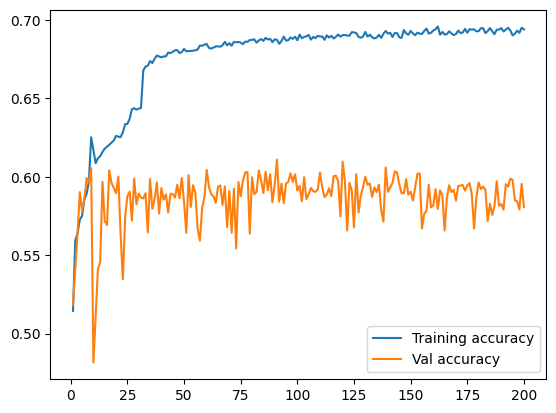

MOEX
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-10-72d26b0a981b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
<ipython-input-10-72d26b0a981b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)


Epoch [1/200] - Training Loss: 0.6830, Val Loss: 0.7243, Training Accuracy: 0.5387, Val Accuracy: 0.6221, Difference: ABS: tensor([-0.3481]), APPR: tensor([-0.8624])
Epoch [2/200] - Training Loss: 0.6636, Val Loss: 0.7440, Training Accuracy: 0.5874, Val Accuracy: 0.6185, Difference: ABS: tensor([-0.2370]), APPR: tensor([-0.5872])
Epoch [3/200] - Training Loss: 0.6554, Val Loss: 0.7452, Training Accuracy: 0.6000, Val Accuracy: 0.6197, Difference: ABS: tensor([-0.3481]), APPR: tensor([-0.8624])
Epoch [4/200] - Training Loss: 0.6480, Val Loss: 0.7658, Training Accuracy: 0.6123, Val Accuracy: 0.6179, Difference: ABS: tensor([-0.4037]), APPR: tensor([-1.])
Epoch [5/200] - Training Loss: 0.6433, Val Loss: 0.7899, Training Accuracy: 0.6204, Val Accuracy: 0.6172, Difference: ABS: tensor([-0.4037]), APPR: tensor([-1.])
Epoch [6/200] - Training Loss: 0.6395, Val Loss: 0.7889, Training Accuracy: 0.6292, Val Accuracy: 0.6156, Difference: ABS: tensor([-0.3481]), APPR: tensor([-0.8624])
Epoch [7/200

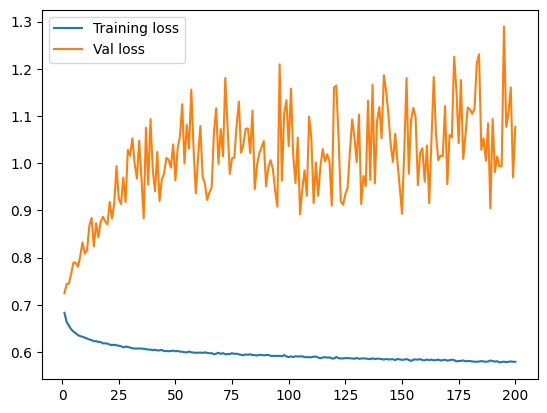

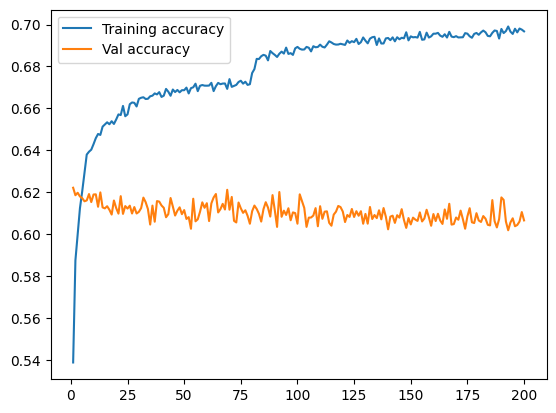

SBER
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-10-72d26b0a981b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
<ipython-input-10-72d26b0a981b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)


Epoch [1/200] - Training Loss: 0.6509, Val Loss: 0.6021, Training Accuracy: 0.6187, Val Accuracy: 0.7188, Difference: ABS: tensor([-0.1514]), APPR: tensor([-0.5477])
Epoch [2/200] - Training Loss: 0.6317, Val Loss: 0.5956, Training Accuracy: 0.6467, Val Accuracy: 0.7205, Difference: ABS: tensor([-0.2764]), APPR: tensor([-1.])
Epoch [3/200] - Training Loss: 0.6237, Val Loss: 0.5730, Training Accuracy: 0.6581, Val Accuracy: 0.7239, Difference: ABS: tensor([-0.2764]), APPR: tensor([-1.])
Epoch [4/200] - Training Loss: 0.6172, Val Loss: 0.5858, Training Accuracy: 0.6667, Val Accuracy: 0.7230, Difference: ABS: tensor([-0.2139]), APPR: tensor([-0.7739])
Epoch [5/200] - Training Loss: 0.6151, Val Loss: 0.6003, Training Accuracy: 0.6699, Val Accuracy: 0.7257, Difference: ABS: tensor([-0.2139]), APPR: tensor([-0.7739])
Epoch [6/200] - Training Loss: 0.6130, Val Loss: 0.5730, Training Accuracy: 0.6711, Val Accuracy: 0.7305, Difference: ABS: tensor([-0.2764]), APPR: tensor([-1.])
Epoch [7/200] - 

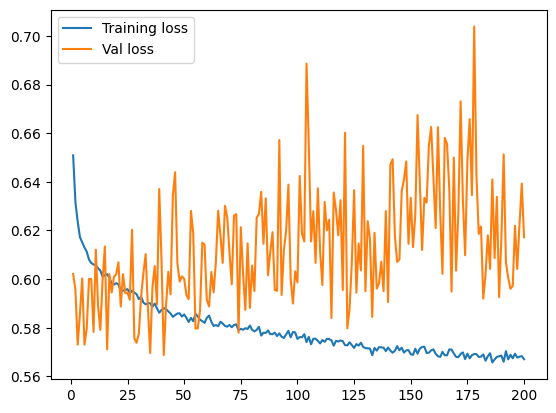

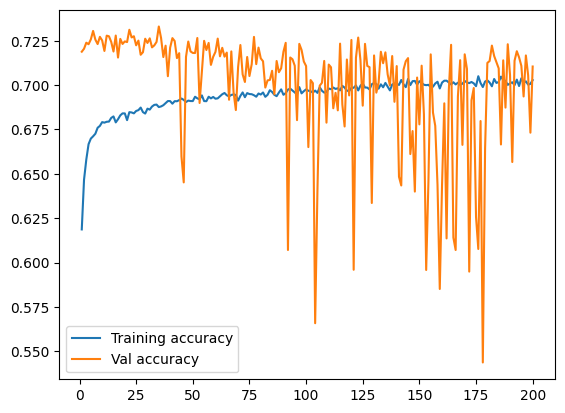

GMKN
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-10-72d26b0a981b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
<ipython-input-10-72d26b0a981b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)


Epoch [1/200] - Training Loss: 0.6792, Val Loss: 0.7171, Training Accuracy: 0.5917, Val Accuracy: 0.5018, Difference: ABS: tensor([0.2090]), APPR: tensor([0.6032])
Epoch [2/200] - Training Loss: 0.6542, Val Loss: 0.7055, Training Accuracy: 0.6642, Val Accuracy: 0.5881, Difference: ABS: tensor([0.2090]), APPR: tensor([0.6032])
Epoch [3/200] - Training Loss: 0.6478, Val Loss: 0.6978, Training Accuracy: 0.6784, Val Accuracy: 0.6176, Difference: ABS: tensor([0.0979]), APPR: tensor([0.2826])
Epoch [4/200] - Training Loss: 0.6430, Val Loss: 0.7176, Training Accuracy: 0.6837, Val Accuracy: 0.6306, Difference: ABS: tensor([-0.0132]), APPR: tensor([-0.0381])
Epoch [5/200] - Training Loss: 0.6360, Val Loss: 0.7123, Training Accuracy: 0.6928, Val Accuracy: 0.6353, Difference: ABS: tensor([0.0979]), APPR: tensor([0.2826])
Epoch [6/200] - Training Loss: 0.6338, Val Loss: 0.7048, Training Accuracy: 0.6932, Val Accuracy: 0.6439, Difference: ABS: tensor([0.2090]), APPR: tensor([0.6032])
Epoch [7/200] 

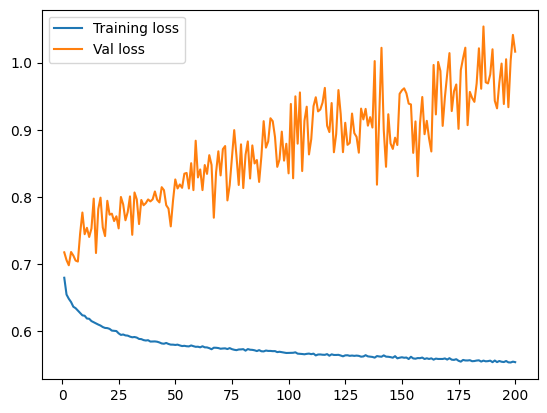

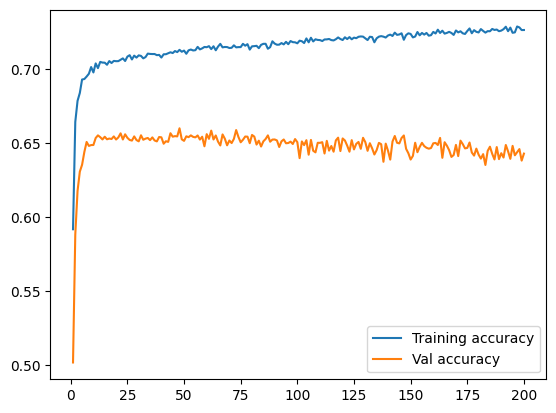

T
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<ipython-input-10-72d26b0a981b>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(self.labels[:training_data_len], dtype=torch.float32)
<ipython-input-10-72d26b0a981b>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_val = torch.tensor(self.labels[training_data_len:], dtype=torch.float32)


Epoch [1/200] - Training Loss: 0.8042, Val Loss: 0.6739, Training Accuracy: 0.4605, Val Accuracy: 0.6002, Difference: ABS: tensor([-0.3813]), APPR: tensor([-0.9574])
Epoch [2/200] - Training Loss: 0.7659, Val Loss: 0.6673, Training Accuracy: 0.4804, Val Accuracy: 0.5959, Difference: ABS: tensor([-0.3813]), APPR: tensor([-0.9574])
Epoch [3/200] - Training Loss: 0.7465, Val Loss: 0.6660, Training Accuracy: 0.4965, Val Accuracy: 0.5969, Difference: ABS: tensor([-0.3813]), APPR: tensor([-0.9574])
Epoch [4/200] - Training Loss: 0.7345, Val Loss: 0.6711, Training Accuracy: 0.5083, Val Accuracy: 0.5972, Difference: ABS: tensor([-0.3813]), APPR: tensor([-0.9574])
Epoch [5/200] - Training Loss: 0.7252, Val Loss: 0.6681, Training Accuracy: 0.5173, Val Accuracy: 0.5963, Difference: ABS: tensor([-0.3474]), APPR: tensor([-0.8723])
Epoch [6/200] - Training Loss: 0.7164, Val Loss: 0.6744, Training Accuracy: 0.5255, Val Accuracy: 0.5954, Difference: ABS: tensor([-0.3474]), APPR: tensor([-0.8723])
Epoc

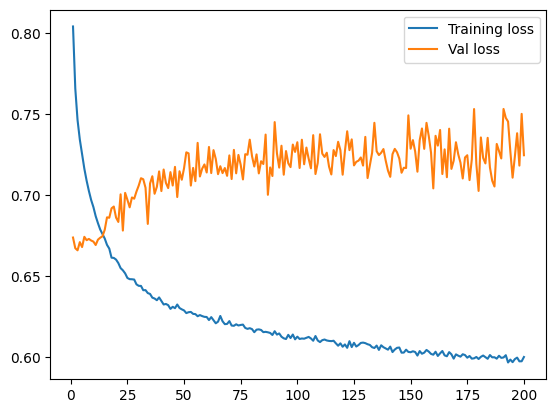

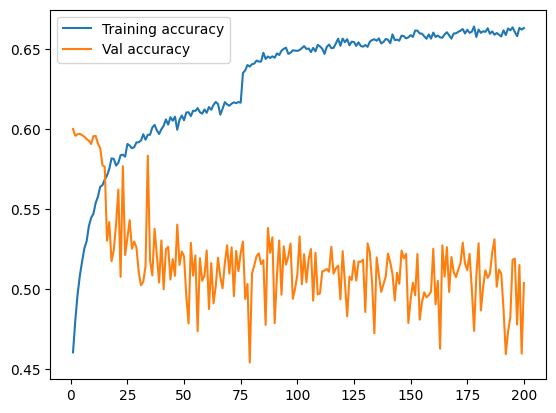

In [ ]:
model_loss = {}
model_acc = {}
models = {}
num_epochs = 200
for dataset in used_names:
  print(dataset)
  dfr = Data(df['features'][dataset][:-160], df['labels'][dataset][160:], 160)
  model, train_hist, val_hist, train_acc_hist, val_acc_hist = build_ANN(dfr,
                                                              num_epochs, 64)
  # torch.save(model.state_dict(), '/content/drive/MyDrive/models/' + dataset + '_model.pth')

  model_loss[dataset] = val_hist
  model_acc[dataset] = val_acc_hist
  models[dataset] = model

  plot_loss(train_hist, val_hist, 'loss', num_epochs)
  plot_loss(train_acc_hist, val_acc_hist, 'accuracy', num_epochs)

Итак, некоторые данные удалось обучить до 0.75 accuracy на некоторых данных. Лучшие предсказания получились для данных, взятых с банков (SBER, T) и нефтяных компаний. Что, в некотором роде, обосновано.


In [ ]:
# Добавляем новый столбец, в котором будем считать количество единиц в 'labels'
dat = df
dat['count_ones'] = dat['labels'].apply(
    lambda x: sum(1 for i in x if i == 1.0) / len(x))
df_sorted = dat.sort_values(by='count_ones', ascending=False)

# Выводим отсортированный DataFrame
print(df_sorted['count_ones'])

T       0.504677
FEES    0.425890
AFLT    0.406186
MOEX    0.388980
GMKN    0.360473
SBER    0.350670
LKOH    0.344953
Name: count_ones, dtype: float64


Дополнительно можно заметить, что лучше всего получилось "угадывать" самые "сбалансированные" (с точки зрения отношения единиц к нулям) данные и наоборот, самые несбалансированные данные. (Хотя, есть ощущуение, что не в этом дело)